### diag_dissip_subdomain
* plot results from online diagnostics dissipation
mean of low-pass

In [1]:
%matplotlib notebook
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset

krypton = "/data0/project/vortex/lahaye/"

In [2]:
simul = 'luckym2'

#path_data = krypton+"local_ruchba/{0}/{1}_diags_ek_avg.00000.nc".format(simul.upper(),simul) 
path_data = krypton+"local_ruchba/{0}/{1}_diags_ek_lf_extracted.nc".format(simul.upper(),simul) 
path_grid = krypton+'lucky_corgrd.nc'

dosavefig = False
picdir = "./pictures/"

hmin = 100 # minimum depth for mask
rho0 = 1025

In [5]:
### load grid and data
nc = Dataset(path_grid, "r")
h = nc.variables['h'][:]
lon = nc.variables['lon_rho'][:]
lat = nc.variables['lat_rho'][:]
pm = nc.variables['pm'][:]
pn = nc.variables['pn'][:]
nc.close()
dx, dy = (1./pm).mean(), (1./pn).mean()
Ny, Nx = h.shape

nc = Dataset(path_data)
data = {}
print("loading", end=" ")
for key,val in nc.variables.items():
    if val.ndim == 3:
        data[key] = val[:].mean(axis=0)*rho0*pm*pn
        print(key, end=", ")
print("finished")
nc.close()

# correct vmix to exclude drag and baro
data['ke_vmix'] -= data['ke_drag']+data['ke_wind']+data['ke_baro']
data['ke_hadv'] -= data['ke_hdiff']
data['ke_prsgrd'] += data['ke_baro']

loading ke_hadv, ke_hdiff, ke_vadv, ke_cor, ke_prsgrd, ke_hmix, ke_vmix, ke_rate, ke_vol, ke_nudg, ke_wind, ke_drag, ke_baro, finished


<IPython.core.display.Javascript object>


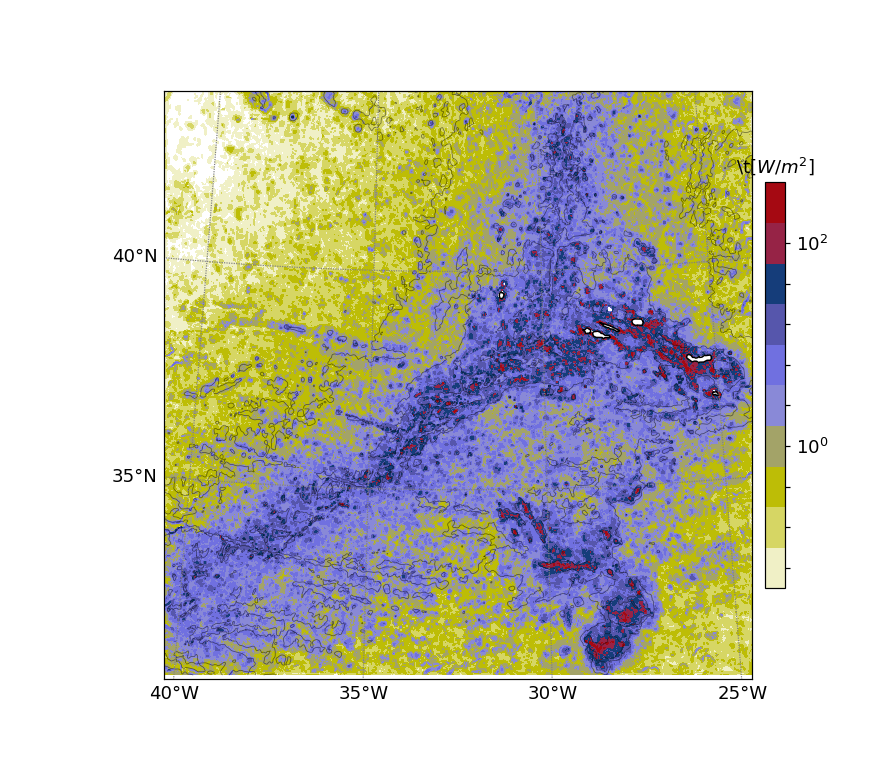

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


total: 7288.2 GW, mean: 3252.44 mW/m^2
hdiff: 4.4 GW, mean: 1.95 mW/m^2
vmix-drag: 0.6 GW, mean: 0.27 mW/m^2
drag: 2.3 GW, mean: 1.04 mW/m^2


In [6]:
toplot = data['ke_hdiff'] + data['ke_vmix'] + data['ke_drag'] #
toplot = -toplot * 1e3 # mW/m^2
mask = h>hmin

# plotting parameters
fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 5
Lx,Ly    = dx*Nx, dy*Ny # extend in m
cmap = plt.get_cmap('gist_stern_r')
zlevs=[0,2000,3500]
topocol='k'     # isobath. contour color
grdcol='gray'   # grid color
mascale = "log" # 'linear'# 
if mascale == "linear":
    valmax = 0.1
    levels = np.linspace(0,valmax,11)
    levels[0] = levels[1]/2
elif mascale == 'log':
    valmin = 4e-2
    valmax = 4e2
    levels = np.logspace(np.log10(valmin),np.log10(valmax),11)
    
fig = plt.figure(figsize=(8,7))
ax = plt.subplot(111)
bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='black')
bm.fillcontinents(color='white')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)

bm.contour(xx,yy,h,zlevs,colors=topocol,linewidths=0.5,alpha=0.5)
if mascale == 'linear':
    hpc = bm.contourf(xx,yy,np.ma.masked_array(toplot,~mask),levels,\
                      cmap=cmap,extend='max',linestyles=None)
    hcb = bm.colorbar(hpc,extend="max")
    hcb.set_ticks(np.r_[0,hcb.get_ticks()])
    hcb.formatter.set_powerlimits((-1, 1))
    hcb.formatter.set_useMathText(True)
    hcb.update_ticks()
elif mascale == 'log':
    hpc = bm.contourf(xx,yy,np.ma.masked_array(toplot,~mask),levels,\
                      cmap=cmap, norm=mpl.colors.LogNorm(), linestyles=None)
    hcb = plt.colorbar(hpc,extend="both", fraction=.03, pad=.02)
    hcb.set_ticks(levels/4)
    hcb.update_ticks()
for item in hpc.collections:
    item.set_rasterized('True')
hcb.ax.tick_params(labelsize=fs)
hcb.ax.set_title("\t"+r'[$W/m^2$]', fontsize=fs, ha="center")

print('total: {0:.1f} GW, mean: {1:.2f} mW/m^2'.format(
    np.nansum(toplot[mask]*dx*dy)/1e12,np.nanmean(toplot[mask])))
prov = -data['ke_hdiff']
print('hdiff: {0:.1f} GW, mean: {1:.2f} mW/m^2'.format(
    np.nansum(prov[mask]*dx*dy)/1e9,np.nanmean(prov[mask])*1e3))
prov = -data['ke_vmix']
print('vmix-drag: {0:.1f} GW, mean: {1:.2f} mW/m^2'.format(
    np.nansum(prov[mask]*dx*dy)/1e9,np.nanmean(prov[mask])*1e3))
prov = -data['ke_drag']
print('drag: {0:.1f} GW, mean: {1:.2f} mW/m^2'.format(
    np.nansum(prov[mask]*dx*dy)/1e9,np.nanmean(prov[mask])*1e3))


<IPython.core.display.Javascript object>


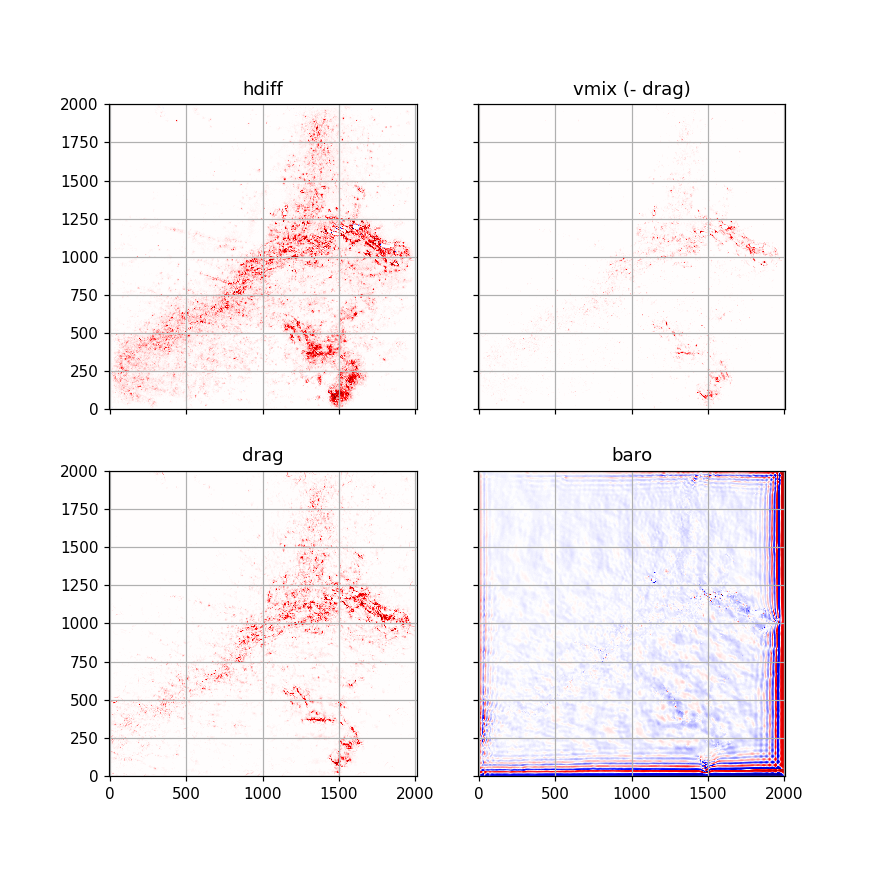

In [67]:
vamp = 2e-1
norm = mpl.colors.SymLogNorm(linthresh=vamp/10, linscale=1, vmin=-vamp, vmax=vamp)
cmap = "seismic_r"

fig, bxs = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
axs = bxs.ravel()
ax = axs[0]
ax.pcolormesh(data['ke_hdiff'], cmap=cmap, norm=norm)
ax.set_title('hdiff')
ax = axs[1]
ax.pcolormesh(data['ke_vmix'], cmap=cmap, norm=norm)
ax.set_title('vmix (- drag)')
ax = axs[2]
ax.pcolormesh(data['ke_drag'], cmap=cmap, norm=norm)
ax.set_title('drag')
ax = axs[3]
ax.pcolormesh(data['ke_baro'], cmap=cmap, norm=norm)
ax.set_title('baro')

for ax in axs:
    ax.set_aspect(1)
    ax.grid(True)

In [28]:
fig.savefig("pictures/"+simul+"_2Diss_total.png", magnification="auto", bbox_inches="tight", dpi=150)

<IPython.core.display.Javascript object>


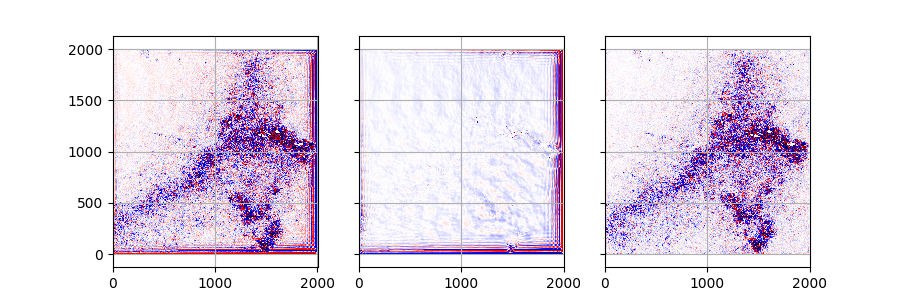

ke_prsgrd: 2.44 mW/m^2
ke_baro: 0.95 mW/m^2
prsgrd + baro: 3.38 mW/m^2


In [47]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9,3))
ax = axs[0]
toplot = data["ke_prsgrd"]
ax.pcolormesh(toplot, cmap=cmap, norm=norm)
print('ke_prsgrd: {:.2f} mW/m^2'.format(toplot[mask].mean()*1e3))

ax = axs[1]
toplot = data["ke_baro"]
ax.pcolormesh(toplot, cmap=cmap, norm=norm)
print('ke_baro: {:.2f} mW/m^2'.format(toplot[mask].mean()*1e3))

ax = axs[2]
toplot = data["ke_prsgrd"] + data["ke_baro"]
ax.pcolormesh(toplot, cmap=cmap, norm=norm)
print('prsgrd + baro: {:.2f} mW/m^2'.format(toplot[mask].mean()*1e3))

for ax in axs: 
    ax.grid(True)
    ax.set_aspect(1)

<IPython.core.display.Javascript object>


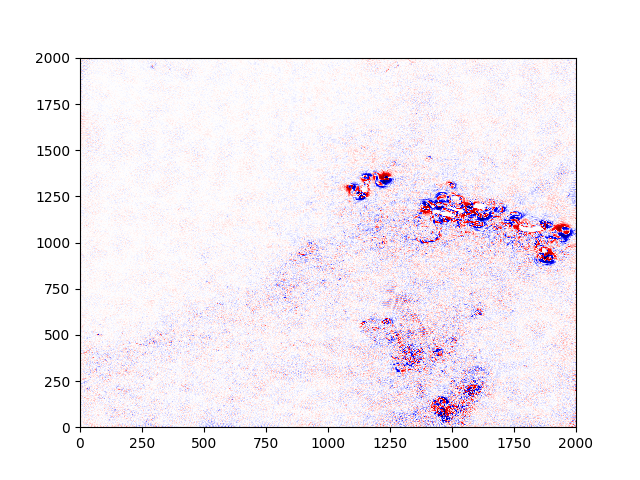

mean: -0.02 mW/m^2


In [49]:
fig = plt.figure()
toplot = data['ke_rate'] #data['ke_hadv'] + data['ke_vadv'] + data['ke_cor'] + data['ke_prsgrd'] + data['ke_baro']
plt.pcolormesh(toplot, norm=norm, cmap=cmap)
print("mean: {:.2f} mW/m^2".format(toplot[mask].mean()*1e3))

In [50]:
.57/.43

1.3255813953488371

<IPython.core.display.Javascript object>


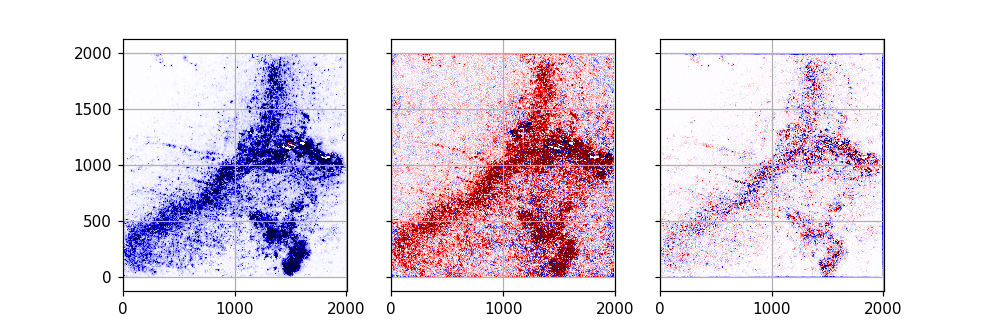

-2.80739207027
2.88681564215
-0.0957388652684


In [74]:
# try to split bclin, btrop, residual

drag_bc = .57
drag_bt = 1-drag_bc
vamp = 10*1e-3
cmap = "seismic"

doto = [data['ke_vmix'] + data['ke_drag']*drag_bc + data['ke_hdiff'],
        data['ke_hadv'] + data['ke_vadv'] + data['ke_prsgrd'] + data['ke_baro'] + data['ke_drag']*drag_bt ,
        data['ke_nudg'] + data['ke_vol'] + data['ke_cor'] +data['ke_wind'] + data['ke_hmix']]

fig, axs = plt.subplots(1, len(doto), sharex=True, sharey=True, figsize=(3*len(doto),3))
for ia,ax in enumerate(axs):
    ax.pcolormesh(doto[ia], vmin=-vamp, vmax=vamp, cmap=cmap)
    print(doto[ia][mask].mean()*1e3)
    ax.set_aspect(1)
    ax.grid(True)

<IPython.core.display.Javascript object>


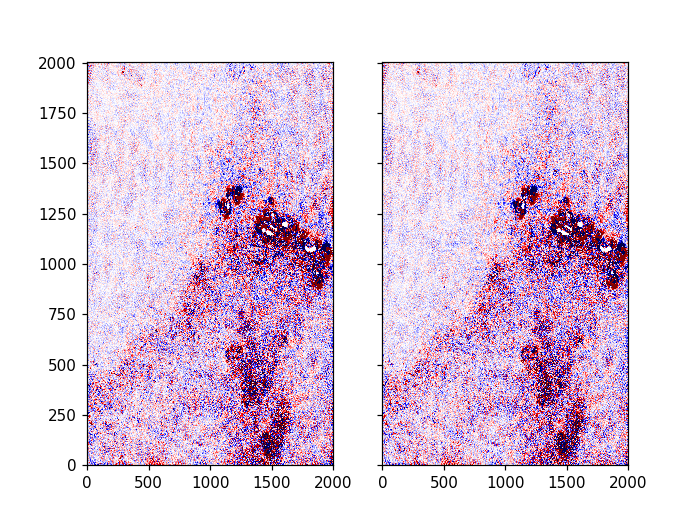

-0.0163152933931 -0.0163164692861
-0.0165036047302 -0.0165048067059


In [75]:
### check wether it closes or not: it does

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].pcolormesh(doto[0]+doto[1]+doto[2], cmap='seismic', vmin=-vamp, vmax=vamp)
axs[1].pcolormesh(data['ke_rate'], cmap='seismic', vmin=-vamp, vmax=vamp)
print((doto[0]+doto[1]+doto[2])[mask].mean()*1e3, data['ke_rate'][mask].mean()*1e3)
print(np.nanmean(doto[0]+doto[1]+doto[2])*1e3, np.nanmean(data['ke_rate'])*1e3)

<IPython.core.display.Javascript object>


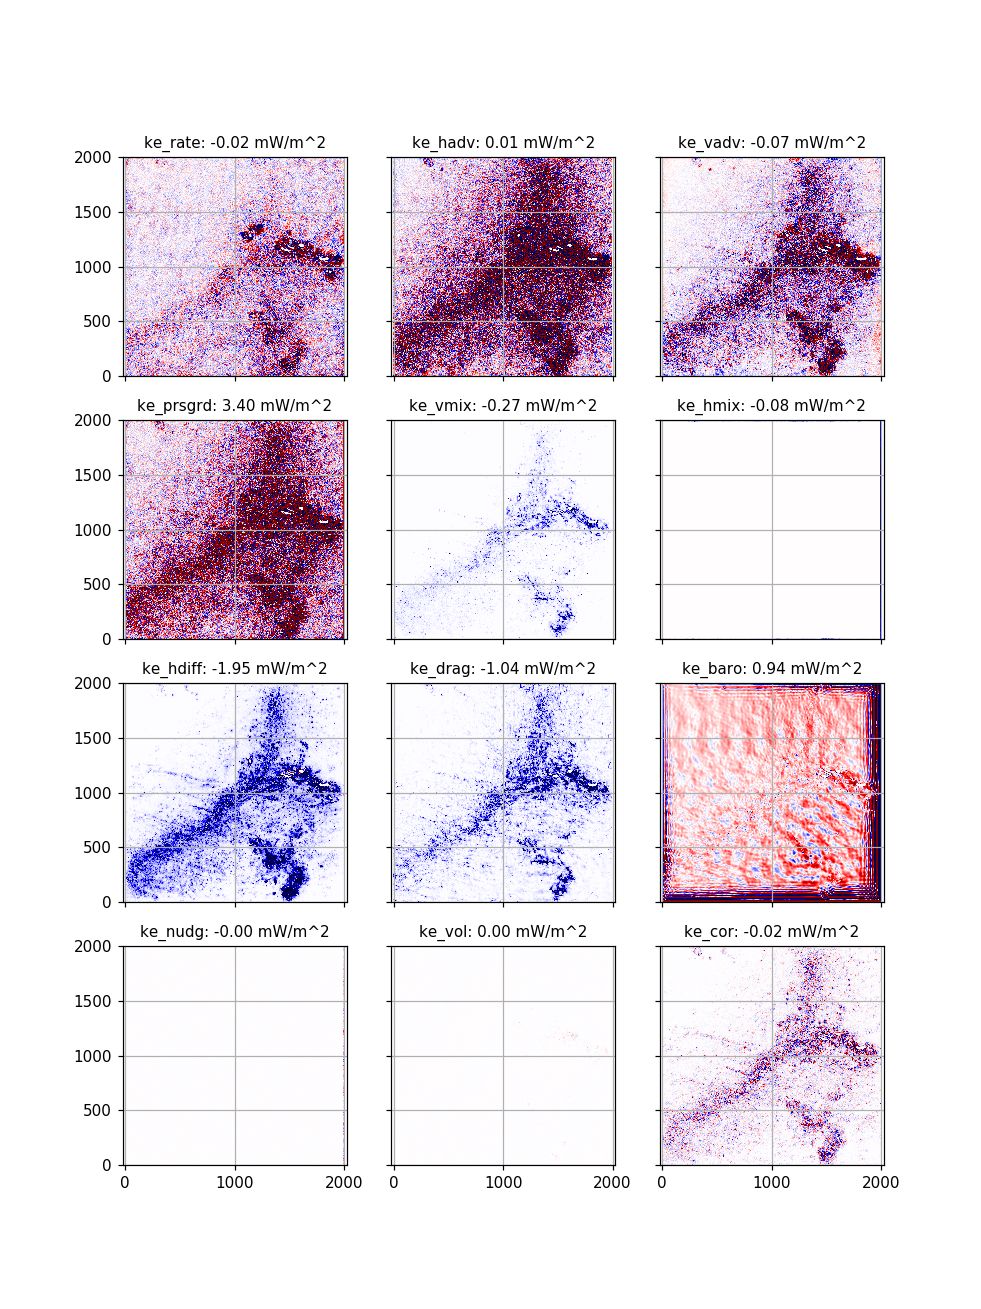

In [86]:
# plot every terms
fields = ['ke_rate', 'ke_hadv', 'ke_vadv', 'ke_prsgrd',
          'ke_vmix', 'ke_hmix', 'ke_hdiff', 'ke_drag', 
          'ke_baro', 'ke_nudg', 'ke_vol', 'ke_cor']

fig, axs = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(9,12))
for ia,fi in enumerate(fields):
    ax = axs.ravel()[ia]
    ax.pcolormesh(data[fi], vmin=-vamp, vmax=vamp, cmap=cmap)
    ax.set_title("{0}: {1:.2f} mW/m^2".format(fi, np.nanmean(data[fi])*1e3), fontsize=10)
    ax.set_aspect(1)
    ax.grid(True)
    

In [85]:
fig.savefig("pictures/LUCKYM2/luckym2_diagdiss_allterms_lf.png",
            magnification="auto", bbox_inches="tight", dpi=150)